In [6]:
%load_ext autoreload
%autoreload 2
from biometric_system import BiometricSystem
from anomaly_detectors.M2005 import M2005 
from anomaly_detectors import thresholds
from data_stream import data_stream
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

import ipdb
import os, sys
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import random
import copy
import IPython.display as ipd


df = pd.read_csv('dados/DSL-Modificado.csv', delimiter = ',', index_col = [0])
df = df.drop(['rep'], axis=1)
users = df['subject'].unique()

# Para sistema Aditivado, basta nao comentar linha da coluna ROUBO
#df['ROUBO'] = df['subject']



def Average(lst):
    x = sum(lst)
    y = len(lst)
    a = (round(x,6) / round(y))
    return a


def split_data_enrollment(dataset, column, n_samples):
    data_to_enrollment = dict()

    for value in dataset[column].unique():
        
        data_to_enrollment.setdefault(value, dataset.loc[dataset[column]==value].iloc[:(n_samples//2)].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    return data_to_enrollment

def split_data_validation(dataset, column, n_samples):
    data_to_validation = dict()

    for value in dataset[column].unique():
        
        data_to_validation.setdefault(value, dataset.loc[dataset[column]==value].iloc[(n_samples//2):n_samples].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    return data_to_validation


def split_data_recognition(dataset, column, n_samples):
    data_to_recognition = dict()

    for value in dataset[column].unique():
 
        data_to_recognition.setdefault(value, dataset.loc[dataset[column]==value].iloc[:n_samples].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    
    return data_to_recognition

def split_data(dataset, column, n_samples):
    data_to_enrollment = dict()
    data_to_validation = dict()
    data_to_recognition = dict()

    for value in dataset[column].unique():
        
        #Treinamento, pegando dados de usuarios 
        data_to_enrollment.setdefault(value, dataset.loc[dataset[column]==value].iloc[:(n_samples//2)].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))

        # Definir o limiar de decisao dos algoritmos de classificacao
        data_to_validation.setdefault(value, dataset.loc[dataset[column]==value].iloc[(n_samples//2):n_samples].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))

        # Criar o fluxo de teste
        data_to_recognition.setdefault(value, dataset.loc[dataset[column]==value].iloc[n_samples:].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    
    return data_to_enrollment,data_to_validation, data_to_recognition



FALSE = []
SLIDING = []
GROWING = []
DOUBLEPARALEL = []


#--------------------------------------------------------------------------------------------------------------#  
#Parametros

R = 10
perc = 0.5
impostor_rate = 0.30
rate_external_impostor = 0

#--------------------------------------------------------------------------------------------------------------# 
#Separação de index, primeiro pra treino, segundo para validação e teste
# Dependendo do teste é necessario trocar a linha 43 ("Separação por Index")

sessionIndex1 = 1
# usando !sessionIndex1, estou usando todas as outras sessoes

#--------------------------------------------------------------------------------------------------------------# 
#Separação de usuarios

len_reg_users = int(len(users) * perc)

kfold = KFold(n_splits=2, shuffle=True, random_state=R)
splits = kfold.split(users)

#--------------------------------------------------------------------------------------------------------------# 
#Registro de usuarios

for i, (reg_users, not_reg_users) in enumerate(splits):

    internal_users = copy.deepcopy(df.loc[df['subject'].isin(users[reg_users])])
    external_users = copy.deepcopy(df.loc[~df['subject'].isin(users[reg_users])])
    
    frames = [internal_users, external_users]

    internal_users = pd.concat(frames)

#--------------------------------------------------------------------------------------------------------------#  
#Separação por Index

dataS1 = internal_users.loc[(internal_users['sessionIndex'] == sessionIndex1)]
dataS2 = internal_users.loc[(internal_users['sessionIndex'] != sessionIndex1)]

#--------------------------------------------------------------------------------------------------------------#  
# Dados para Treino, Validação e Reconhecimento

#Treinamento, pegando dados de usuarios 
data_to_enrollment = split_data_enrollment(dataS1, column='subject', n_samples=50)

# Definir o limiar de decisao dos algoritmos de classificacao
data_to_validation = split_data_validation(dataS1, column='subject', n_samples=50)

# Criar o fluxo de teste
data_to_recognition = split_data_recognition(dataS2, column='subject', n_samples=350)

_, _, external_users_data = split_data(external_users, column='subject', n_samples=50)


#--------------------------------------------------------------------------------------------------------------# 
#Sistema sem Adaptação (False)

detector = M2005()
adaptive = "False"
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics = dict()
auxiliar_false = {}

for j, genuine in enumerate(system.users.keys()):

    ipd.clear_output(wait=True)
    print(f"Rodando False:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")


    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)

    test_stream, y_true, amostras_noadaptative_genuinas, amostras_noadaptative_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)


    y_pred, lista_nao_usadas_false, lista_usadas_false, lista_adaptacao_false  = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold, adaptive_TESTE=adaptive, return_scores=False)
    

    fmr, fnmr, b_acc,  y_genuine , y_impostor = system.compute_metrics(y_true, y_pred)
    
    auxiliar_false[genuine] = y_genuine.value_counts()[1], y_impostor.value_counts()[0]


    for met in ['fmr','fnmr','b_acc']:
        metrics.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))


usuarios = metrics.keys()
result = pd.DataFrame(metrics.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])
FALSE.append(metrics_mean['b_acc_mean'].mean())

#--------------------------------------------------------------------------------------------------------------# 

#Sistema com Adaptação (SlidingWindow)

detector = M2005()
adaptive= "SlidingWindow"
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics_adaptativo_sliding = dict()

lista_nao_usadas_sliding = list()
lista_usadas_sliding = list()
auxiliar_sliding = {}
contagem_adapt_sliding = {}


for j, genuine in enumerate(system.users.keys()):


    ipd.clear_output(wait=True)
    print(f"Rodando Sliding:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")
    print(f"Genuino:", genuine)

    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)
    
    test_stream, y_true,amostras_sliding_genuinas,amostras_sliding_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)

    y_pred, lista_nao_usadas_sliding2, lista_usadas_sliding2,lista_adaptacao_sliding = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold, adaptive_TESTE=adaptive, return_scores=False)

    lista_nao_usadas_sliding.append(lista_nao_usadas_sliding2)
    lista_usadas_sliding.append(lista_usadas_sliding2)

    fmr, fnmr, b_acc,  clas_genuine_sliding , clas_impostor_sliding = system.compute_metrics(y_true, y_pred)
    
    adapt_genuine_sliding, adapt_impostor_sliding = system.contagem_adaptacao(y_true, lista_adaptacao_sliding)
    
    contagem_adapt_sliding[genuine] = adapt_genuine_sliding.value_counts()[1],adapt_impostor_sliding.value_counts()[0]
    
    auxiliar_sliding[genuine] = clas_genuine_sliding.value_counts()[1], clas_impostor_sliding.value_counts()[0]
    
    for met in ['fmr','fnmr','b_acc']:
        metrics_adaptativo_sliding.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))
        

usuarios = metrics_adaptativo_sliding.keys()
result = pd.DataFrame(metrics_adaptativo_sliding.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_adaptativo_sliding_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])

SLIDING.append(metrics_adaptativo_sliding_mean['b_acc_mean'].mean())

#--------------------------------------------------------------------------------------------------------------#  
#Sistema com Adaptação (GrowingWindow)

detector = M2005()
adaptive= 'GrowingWindow'
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics_adaptativo_growing = dict()
lista_nao_usadas_growing = list()
lista_usadas_growing = list()
auxiliar_growing = {}
contagem_adapt_growing = {}

for j, genuine in enumerate(system.users.keys()):

    ipd.clear_output(wait=True)
    print(f"Rodando Growing:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")

    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)
    test_stream, y_true,amostras_growing_genuinas,amostras_growing_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)

    y_pred, lista_nao_usadas_growing2, lista_usadas_growing2, lista_adaptacao_growing = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold,adaptive_TESTE=adaptive, return_scores=False)

    lista_nao_usadas_growing.append(lista_nao_usadas_growing2)
    lista_usadas_growing.append(lista_usadas_growing2)
    
    fmr, fnmr, b_acc, clas_genuine_growing , clas_impostor_growing= system.compute_metrics(y_true, y_pred)
    
    adapt_genuine_growing, adapt_impostor_growing = system.contagem_adaptacao(y_true, lista_adaptacao_growing)
    
    contagem_adapt_growing[genuine] = adapt_genuine_growing.value_counts()[1],adapt_impostor_growing.value_counts()[0]
    
    auxiliar_growing[genuine] = clas_genuine_growing.value_counts()[1], clas_impostor_growing.value_counts()[0]

    for met in ['fmr','fnmr','b_acc']:
        metrics_adaptativo_growing.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))

usuarios = metrics_adaptativo_growing.keys()    
result = pd.DataFrame(metrics_adaptativo_growing.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_adaptativo_growing_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])

GROWING.append(metrics_adaptativo_growing_mean['b_acc_mean'].mean())

#--------------------------------------------------------------------------------------------------------------# 
#Sistema com Adaptação (DoubleParallel)
detector = M2005()
adaptive= 'DoubleParallel'
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics_adaptativo_double = dict()
lista_nao_usadas_double = list()
lista_usadas_double = list()
auxiliar_double = {}
contagem_adapt_double = {}

for j, genuine in enumerate(system.users.keys()):

    ipd.clear_output(wait=True)
    print(f"Rodando Double:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")

    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)
    test_stream, y_true,amostras_double_genuinas,amostras_double_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)


    y_pred, lista_nao_usadas_double2, lista_usadas_double2,lista_adaptacao_double = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold,adaptive_TESTE=adaptive, return_scores=False)

    lista_nao_usadas_double.append(lista_nao_usadas_double2)
    lista_usadas_double.append(lista_usadas_double2)

    fmr, fnmr, b_acc,  clas_genuine_double , clas_impostor_double = system.compute_metrics(y_true, y_pred)
    
    adapt_genuine_double,adapt_impostor_double = system.contagem_adaptacao(y_true, lista_adaptacao_double)
    
    contagem_adapt_double[genuine] = adapt_genuine_double.value_counts()[1],adapt_impostor_double.value_counts()[0]

    auxiliar_double[genuine] = clas_genuine_double.value_counts()[1], clas_impostor_double.value_counts()[0]

    for met in ['fmr','fnmr','b_acc']:
        metrics_adaptativo_double.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))


usuarios = metrics_adaptativo_double.keys()    
result = pd.DataFrame(metrics_adaptativo_double.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_adaptativo_double_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])

DOUBLEPARALEL.append(metrics_adaptativo_double_mean['b_acc_mean'].mean())


Rodando Sliding:2
Testando usuário 51/51
Genuino: s057


'\'\n#--------------------------------------------------------------------------------------------------------------#  \n#Sistema com Adaptação (GrowingWindow)\n\ndetector = M2005()\nadaptive= \'GrowingWindow\'\nsystem = BiometricSystem(detector=detector, random_state=R)\nsystem.enrollment(dataset=data_to_enrollment, adaptive=adaptive)\n\ndecision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)\n\nmetrics_adaptativo_growing = dict()\nlista_nao_usadas_growing = list()\nlista_usadas_growing = list()\nauxiliar_growing = {}\ncontagem_adapt_growing = {}\n\nfor j, genuine in enumerate(system.users.keys()):\n\n    ipd.clear_output(wait=True)\n    print(f"Rodando Growing:{R}")\n    print(f"Testando usuário {j+1}/{len(system.users.keys())}")\n\n    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)\n    test_stream, y_true,amostras_growing_genuinas,amostras_growing_impostoras = d

<h1>GRÁFICOS DE MÉTRICAS</h1>

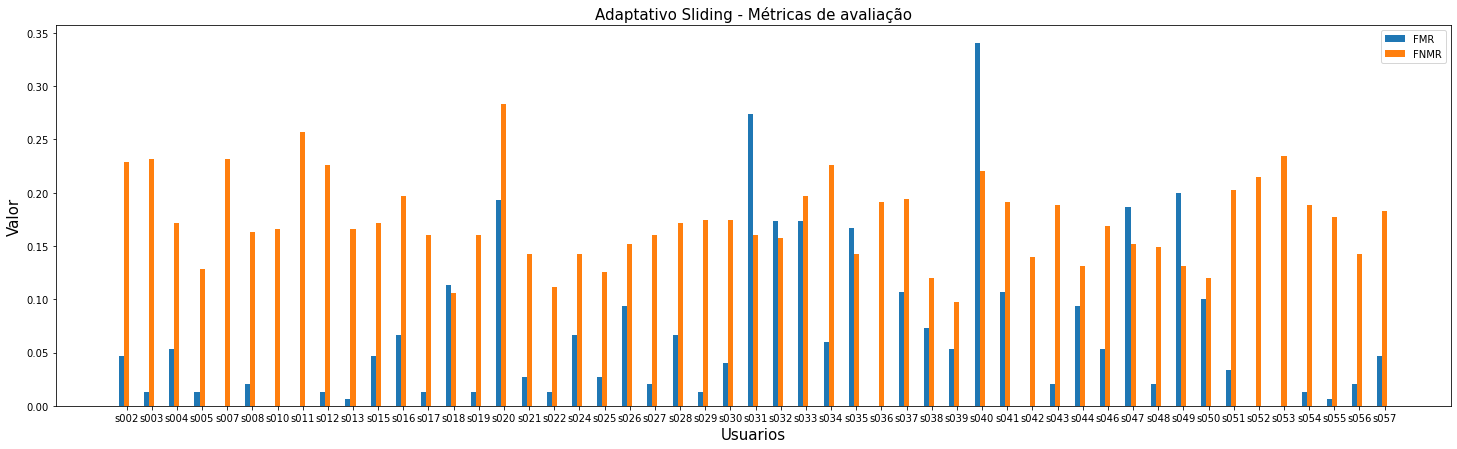

In [7]:
#SLIDING


metrics_adaptativo_sliding_mean = metrics_adaptativo_sliding_mean.sort_values(by=['Usuarios'])
X = metrics_adaptativo_sliding_mean['Usuarios']
fmr_mean = metrics_adaptativo_sliding_mean['fmr_mean']
fnmr_mean = metrics_adaptativo_sliding_mean['fnmr_mean']
b_acc = metrics_adaptativo_sliding_mean['b_acc_mean']

  
plt.rcParams['figure.figsize'] = [25, 7]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, fmr_mean, 0.2, label = 'FMR')
plt.bar(X_axis+ 0, fnmr_mean, 0.2, label = 'FNMR')
#plt.bar(X_axis + 0.2, b_acc, 0.2, label = 'b_acc')


plt.xticks(X_axis, X,fontsize=10)
plt.xlabel("Usuarios", fontsize=15)
plt.ylabel("Valor", fontsize=15)
plt.title("Adaptativo Sliding - Métricas de avaliação", fontsize=15)
plt.legend()
plt.show()


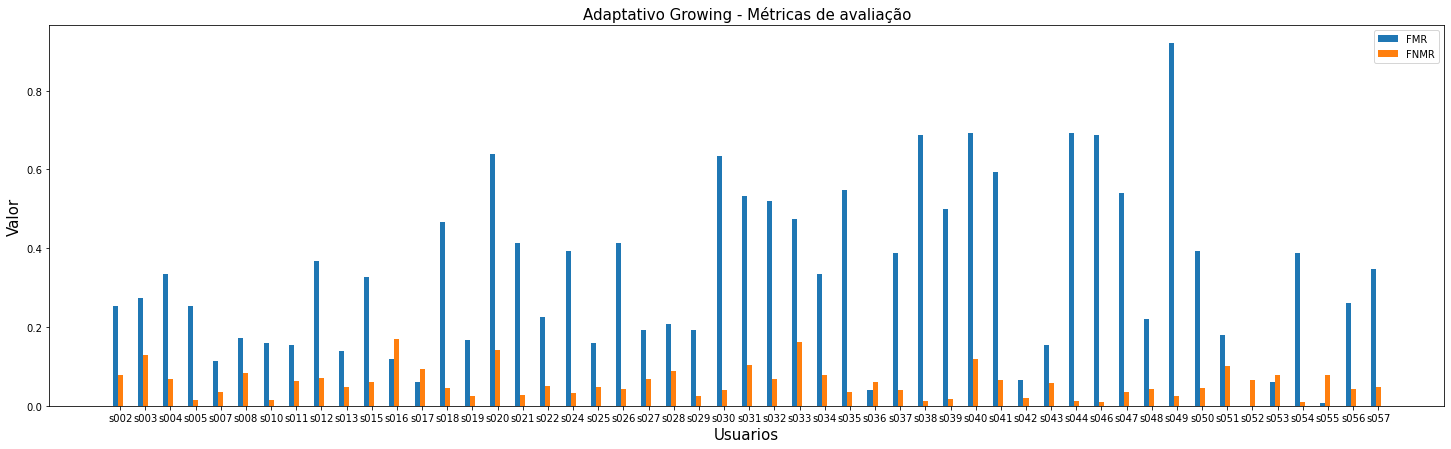

In [3]:
#GROWING

metrics_adaptativo_growing_mean = metrics_adaptativo_growing_mean.sort_values(by=['Usuarios'])
X = metrics_adaptativo_growing_mean['Usuarios']
fmr_mean = metrics_adaptativo_growing_mean['fmr_mean']
fnmr_mean = metrics_adaptativo_growing_mean['fnmr_mean']
b_acc = metrics_adaptativo_growing_mean['b_acc_mean']

  
plt.rcParams['figure.figsize'] = [25, 7]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, fmr_mean, 0.2, label = 'FMR')
plt.bar(X_axis + 0, fnmr_mean, 0.2, label = 'FNMR')
#plt.bar(X_axis + 0.2, b_acc, 0.2, label = 'b_acc')

plt.xticks(X_axis, X, fontsize=10)
plt.xlabel("Usuarios", fontsize=15)
plt.ylabel("Valor", fontsize=15)
plt.title("Adaptativo Growing - Métricas de avaliação", fontsize=15)
plt.legend()
plt.show()


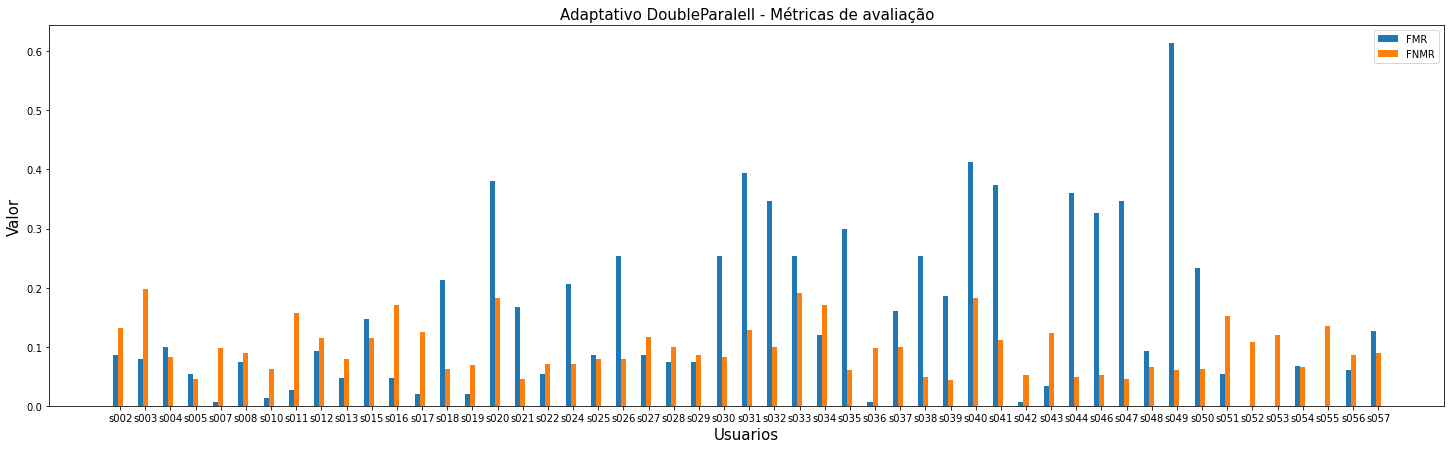

In [4]:
#DoubleParallel

metrics_adaptativo_double_mean = metrics_adaptativo_double_mean.sort_values(by=['Usuarios'])
X = metrics_adaptativo_double_mean['Usuarios']
fmr_mean = metrics_adaptativo_double_mean['fmr_mean']
fnmr_mean = metrics_adaptativo_double_mean['fnmr_mean']
b_acc = metrics_adaptativo_double_mean['b_acc_mean']

  
plt.rcParams['figure.figsize'] = [25, 7]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, fmr_mean, 0.2, label = 'FMR')
plt.bar(X_axis + 0, fnmr_mean, 0.2, label = 'FNMR')
#plt.bar(X_axis + 0.2, b_acc, 0.2, label = 'b_acc')

plt.xticks(X_axis, X, fontsize=10)
plt.xlabel("Usuarios", fontsize=15)
plt.ylabel("Valor", fontsize=15)
plt.title("Adaptativo DoubleParalell - Métricas de avaliação", fontsize=15)
plt.legend()
plt.show()